In [13]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os.path
import subprocess # We will use this to run SExtractor

import numpy as np
import astropy.table
import astropy.io.fits as fits

import mpl_toolkits.axes_grid1
import matplotlib.axes as maxes
import astropy.visualization
from astropy.wcs import WCS

In [123]:
def visualize_image(ax, array, cmap=plt.cm.gray, vmin=None, vmax=None, scale=None, percentile=None, 
                    lower_percentile=None, upper_percentile=None,colorbar=True, show_axis=False,
                   barpos='right'):
    if scale is not None:
        if scale=='zscale':
            vis=astropy.visualization.ZScaleInterval(nsamples=1000, contrast=0.25, max_reject=0.5, 
                                             min_npixels=5, krej=2.5, max_iterations=5)
        elif scale=='minmax': vis=astropy.visualization.MinMaxInterval()
        if percentile is not None: vis=astropy.visualization.PercentileInterval(percentile)
        if (lower_percentile is not None )& (upper_percentile is not None):
                vis=astropy.visualization.AsymmetricPercentileInterval(lower_percentile, upper_percentile )       
        vmin,vmax=vis.get_limits(array)
    print("using vmin, vmax: %.3f, %.3f"%(vmin,vmax))
    if not show_axis: ax.axis('off')
    #ax.axes.xaxis.set_visible(False)
    #ax.axes.yaxis.set_visible(False)
    ec=ax.imshow( array , cmap = cmap , vmin = vmin , vmax =vmax , origin = 'lower')
    if colorbar:
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
        if barpos=='right':
            cax = divider.append_axes(barpos, size="5%", pad=0.1, axes_class=maxes.Axes)
            cbar=plt.gcf().colorbar(ec, cax=cax)
        if barpos=='left':
            if len(ax.get_ylabel()) == 0: pad=0.1
            else: pad=0.9
            cax = divider.append_axes(barpos, size="5%", pad=pad, axes_class=maxes.Axes)
            cbar=plt.gcf().colorbar(ec, cax=cax)
            cbar.ax.yaxis.set_label_position('left')
            cbar.ax.yaxis.set_ticks_position('left')
        if barpos=='top':
            cax = divider.append_axes(barpos, size="5%", pad=0.1, axes_class=maxes.Axes)
            cbar=plt.gcf().colorbar(ec, cax=cax, orientation='horizontal')
            cbar.ax.xaxis.set_label_position('top')
            cbar.ax.xaxis.set_ticks_position('top')
        if barpos=='bottom':
            if len(ax.get_xlabel()) ==0: pad=0.1
            else: pad=0.7
            cax = divider.append_axes(barpos, size="5%", pad=pad, axes_class=maxes.Axes)
            cbar=plt.gcf().colorbar(ec, cax=cax, orientation='horizontal')   
    #ax.grid( color = 'gray') 

In [81]:
#CLUSTER="ACO1914"
CLUSTER="ACO2151"

In [6]:
reddir="/data/PhD/LECTURES/astronomical_observations_astro847/data_clusters/%s/red"%(CLUSTER)
sexdir=os.path.join(reddir,'config' ,"sextractor")
paramspath = os.path.join(sexdir, "params.txt")
configpath = os.path.join(sexdir, "default_config.txt")
convpath = os.path.join(sexdir, "default_conv.txt")

In [7]:
def run_sextractor_dual(detimagepath, measimagepath, catalogpath, configpath, paramspath, convpath):   
    cmd = ["sex", detimagepath+","+measimagepath,
        "-c", configpath,
        "-PARAMETERS_NAME", paramspath,
        "-FILTER_NAME", convpath,
        "-CATALOG_NAME", catalogpath,
        "-CATALOG_TYPE", "ASCII_HEAD",
        "-GAIN", "2.3", # [e/ADU] when binned (unbinned 1.4)
        "-DETECT_MINAREA", "5.0", # min. nb of pixels above threshold
        "-DETECT_THRESH", "1.5", # threshold, in sigmas
        "-BACK_SIZE", "64",
        "-WEIGHT_TYPE", "BACKGROUND", # default is "NONE"
    ]

    res = subprocess.run(cmd, text=True, capture_output=True)

    if(res.returncode != 0): # only need to see this if error occur:
        print(res.stderr)

In [8]:
detimagepath=os.path.join(reddir, "CLIPPED_R.fits")
measimagepath=os.path.join(reddir, "CLIPPED_B.fits")
rcatp=os.path.join(reddir, "R.cat")
bcatp=os.path.join(reddir, "B.cat")

In [9]:
run_sextractor_dual(detimagepath, detimagepath, rcatp, configpath, paramspath, convpath)
run_sextractor_dual(detimagepath, measimagepath, bcatp, configpath, paramspath, convpath)

In [10]:
rcat = astropy.table.Table.read(rcatp, format="ascii.sextractor")
bcat = astropy.table.Table.read(bcatp, format="ascii.sextractor")

In [11]:
i = np.argmax(rcat["FLUX_AUTO"])
rstar = rcat[i]
bstar = bcat[i]
print(rstar["X_IMAGE"], rstar["Y_IMAGE"])
print(bstar["X_IMAGE"], bstar["Y_IMAGE"])

1130.3998 243.7567
1130.3998 243.7567


using vmin, vmax: -29.612, 49.646


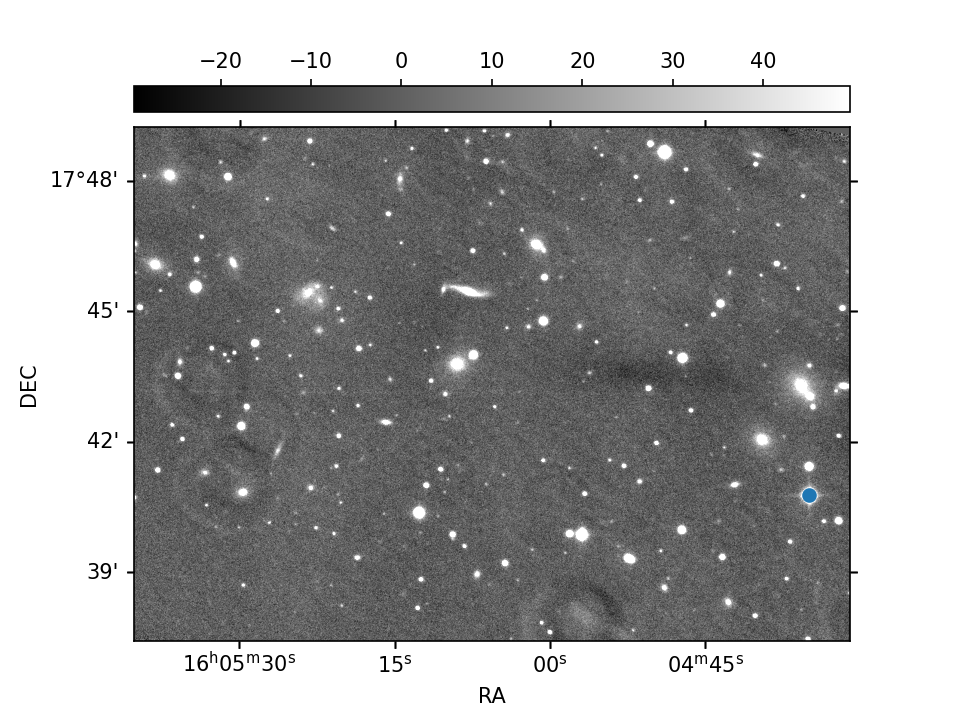

In [168]:
img = fits.getdata(detimagepath)
header = fits.getheader(detimagepath)
wcs = WCS(header)
fig = plt.figure(dpi=150)
ax = fig.subplots(subplot_kw=dict(projection=wcs))
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
visualize_image(ax, img, scale='zscale', colorbar=True, show_axis=True,barpos='top')
ax.scatter(rstar["X_IMAGE"], rstar["Y_IMAGE"])

In [145]:
rinstmag = rstar["MAG_AUTO"]
binstmag = bstar["MAG_AUTO"]
# MAG_AUTO is -2.5*np.log10(FLUX_AUTO)
# We want: mag = instmag + zp

#magnitudes from simbad
if (CLUSTER=="ACO1914"):
    rzp = 11.5 - rinstmag
    bzp = 12.3 - binstmag
    
#magnitudes from simbad
if (CLUSTER=="ACO2151"):
    rzp = 10.69 - rinstmag
    bzp = 11.17 - binstmag
    
print(rzp, bzp)

#print(-2.5*np.log10(rstarflux))
#print(rstar["MAG_AUTO"])


25.8706 25.393900000000002


In [146]:
rinstmag = rstar["MAG_AUTO"]
binstmag = bstar["MAG_AUTO"]
# MAG_AUTO is -2.5*np.log10(FLUX_AUTO)
# We want: mag = instmag + zp

rzp = 11.5 - rinstmag
bzp = 12.3 - binstmag

print(rzp, bzp)

#print(-2.5*np.log10(rstarflux))
#print(rstar["MAG_AUTO"])

26.6806 26.5239


In [147]:
bimage = fits.getdata(measimagepath)
rimage = fits.getdata(detimagepath)

# Size magnitude plot

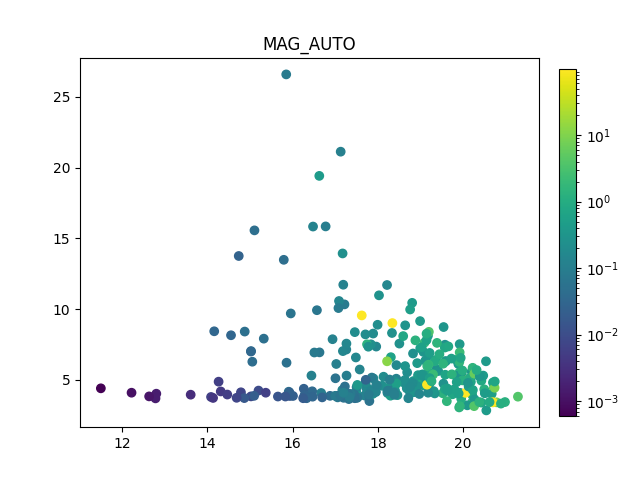

In [148]:
fig = plt.figure()
ax = fig.subplots()
ax.set_title("FWHM_IMAGE")
ax.set_title("MAG_AUTO")
norm=LogNorm(vmin=min(bcat["MAGERR_AUTO"]) , vmax=max(bcat["MAGERR_AUTO"]))
scatter=ax.scatter(rcat["MAG_AUTO"]+rzp,rcat["FWHM_IMAGE"], c=bcat["MAGERR_AUTO"],norm=norm)
cbar = fig.colorbar(scatter, ax=ax, fraction=0.035, pad=0.04)

In [149]:
#selmask = np.logical_and(rcat["MAGERR_AUTO"]<0.5, bcat["MAGERR_AUTO"]<0.5)
#selmask = np.logical_and(selmask, rcat["FWHM_IMAGE"] > 5.0)

s = np.logical_and(rcat["FWHM_IMAGE"] > 5.2, bcat["MAGERR_AUTO"]<0.5, rcat["MAG_AUTO"]+rzp>18.0)
#s = np.logical_and(rcat["FWHM_IMAGE"] > 4.0, bcat["MAGERR_AUTO"]<0.5, rcat["MAG_AUTO"]+rzp>18.0)
#s = np.logical_and(rcat["FWHM_IMAGE"] > 5.0, bcat["MAGERR_AUTO"]<0.5)

print(np.sum(s) / len(rcat))

x = rcat["X_IMAGE"][s]
y = rcat["Y_IMAGE"][s]
r = rcat["MAG_AUTO"][s] + rzp
b = bcat["MAG_AUTO"][s] + bzp
fwhm = rcat["FWHM_IMAGE"][s]

0.2867132867132867


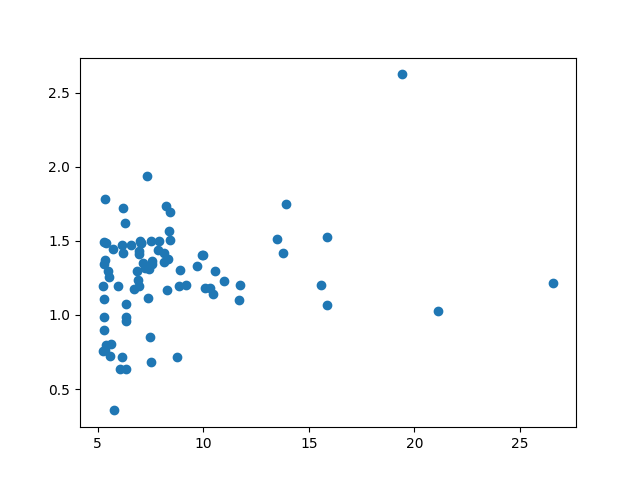

In [150]:
fig = plt.figure()
ax = fig.subplots()
ax.scatter(fwhm, b-r)

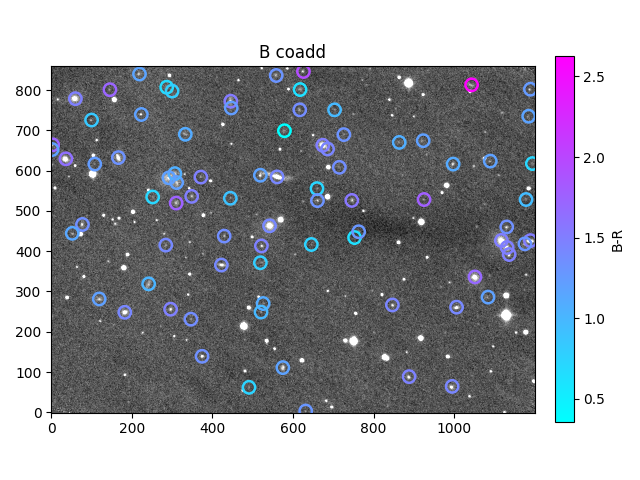

In [151]:
fig = plt.figure()
ax = fig.subplots()
ax.imshow(bimage, cmap="gray", vmin=-10, vmax=20, origin="lower")
ax.set_xlim(auto=False)
ax.set_ylim(auto=False)
ax.set_title("B coadd")
scatter = ax.scatter(x-1, y-1, c=b-r, s=100, cmap="cool", marker="$\u25EF$", linewidths=1.2)
cbar = fig.colorbar(scatter, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("B-R")
fig.tight_layout()

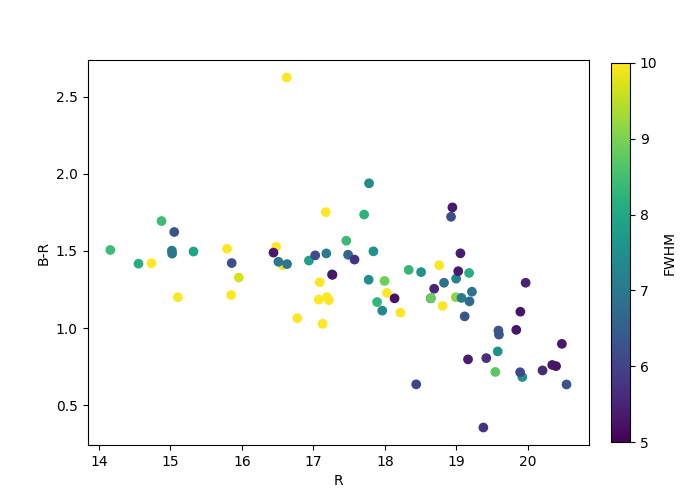

In [152]:
fig = plt.figure(figsize=(7, 5))
ax = fig.subplots()
scatter = ax.scatter(r, b-r, c = fwhm, vmin=5, vmax=10)
#ax.set_title("A simple demonstration plot")
ax.set_xlabel("R")
ax.set_ylabel("B-R")
cbar = fig.colorbar(scatter, ax=ax, fraction=0.035, pad=0.04)
cbar.set_label("FWHM")

#ax.set_xlim(0, 5) # Leave these lines out to get automatic limits
#ax.set_ylim(-2, 2)
#ax.yaxis.grid(True)
#ax.legend() # Automatic legend, uses "label" defined in ax.plot().

#print(cat.colnames) # A list of column names...
#print(len(cat))
#print(np.mean(cat["X_IMAGE"]))
#cat.show_in_notebook()
#print(cat)

In [153]:
rimage = fits.getdata(detimagepath)
bimage = fits.getdata(measimagepath)

In [154]:
bimage *= 10**(-0.4*(bzp-rzp)) * 2.0

In [155]:
10**(-0.4*(bzp-rzp))

1.1552607009692983

In [156]:
"""
from astropy.convolution import Gaussian2DKernel, convolve
rkernel = Gaussian2DKernel(x_stddev=1.0)
rimage = convolve(rimage, rkernel)
bkernel = Gaussian2DKernel(x_stddev=1.0)
bimage = convolve(bimage, bkernel)
"""
pass

In [157]:
gimage = (bimage + rimage)/2.0

In [158]:
from astropy.visualization import make_lupton_rgb

In [166]:
rgbimage = make_lupton_rgb(rimage, gimage, bimage, Q=5, stretch=30)
print(rgbimage.shape)
type(rgbimage)

(860, 1200, 3)


numpy.ndarray

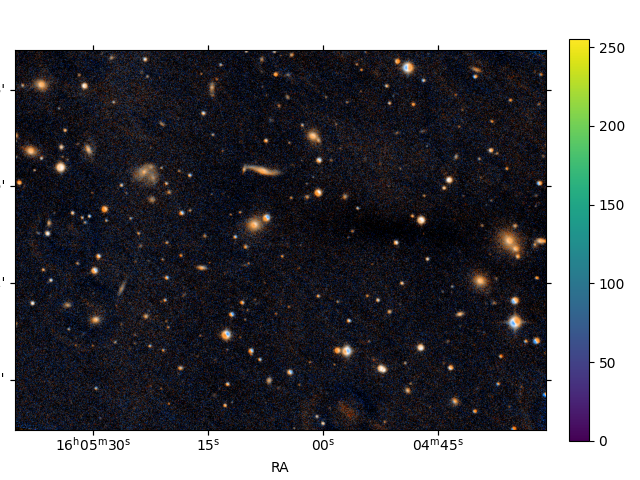

In [176]:
wcs = WCS(header)
fig = plt.figure(dpi=100)
ax = fig.subplots(subplot_kw=dict(projection=wcs))
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
#visualize_image(ax, rgbimage, scale='zscale', colorbar=False, show_axis=True,barpos='top')
scatter=ax.imshow(rgbimage, origin="lower")
cbar = fig.colorbar(scatter, ax=ax, fraction=0.035, pad=0.04)
#ax.axis("off")
fig.tight_layout()


In [25]:
import matplotlib.image
matplotlib.image.imsave("%s_rgbimage.png"%(CLUSTER), rgbimage, origin="lower")